In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')

In [21]:
from __future__ import print_function
from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras import Model
from keras.layers import Dense, LSTM, Input, Dropout, Activation
from keras.optimizers import RMSprop, Adam
from keras.utils.data_utils import get_file
import numpy as np
import random
import sys
import io
from bs4 import BeautifulSoup
import pandas as pd
import requests
import json
from urllib.request import urlopen
import urllib.request
import re 

Using TensorFlow backend.


In [3]:
def get_lyrics(artist,song_title):
    artist = artist.lower()
    song_title = song_title.lower()
    # remove all except alphanumeric characters from artist and song_title
    artist = re.sub('[^A-Za-z0-9]+', "", artist)
    song_title = re.sub('[^A-Za-z0-9]+', "", song_title)
    if artist.startswith("the"):    # remove starting 'the' from artist e.g. the who -> who
        artist = artist[3:]
    url = "http://azlyrics.com/lyrics/"+artist+"/"+song_title+".html"
    
    try:
        content = urllib.request.urlopen(url).read()
        soup = BeautifulSoup(content, 'html.parser')
        lyrics = str(soup)
        # lyrics lies between up_partition and down_partition
        up_partition = '<!-- Usage of azlyrics.com content by any third-party lyrics provider is prohibited by our licensing agreement. Sorry about that. -->'
        down_partition = '<!-- MxM banner -->'
        lyrics = lyrics.split(up_partition)[1]
        lyrics = lyrics.split(down_partition)[0]
        lyrics = lyrics.replace('<br>','').replace('</br>','').replace('</div>','').replace('<br/>','').strip()
        return lyrics
    except Exception as e:
        return "Exception occurred \n" +str(e)

In [57]:

def create_corpus(artist_name):
    url = 'http://lyrics.wikia.com/wiki/' + artist_name
    r = requests.get(url)
    soup = BeautifulSoup(r.text, 'lxml')

    count=0
    data=[]

    # Parse the data to get list of songs and urls
    for album in soup.find_all(class_='album-art'):
        count += 1
        for song in album.find_next('ol').children:
            try:
                a = re.search('\:(.*)', song.b.a['href'])
                data.append({
                    'url': song.b.a['href'],
                    'name': a.group(1)
                })
            except:
                continue
    df = pd.DataFrame(data, columns=["url","name"])
    print('Collecting {0} songs for {1}'.format(df.shape[0],artist_name))
    corpus = ''
    for ind, row in df.iterrows():
        #print('Collecting song: {}'.format(row['name']))
        corpus += '\n' + get_lyrics(artist_name,row['name'])
    print('Writing song corpus for {}'.format(artist_name))
    with open(artist_name+"_corpus.txt", "w") as text_file:
        text_file.write(corpus)



In [58]:
artist_name = 'Pink_Floyd'

In [59]:
def get_corpus_sequence(artist_name):
    from pathlib import Path
    my_file = Path(artist_name+'_corpus.txt')
    if not my_file.is_file():
        print('Corpus doesn\'t already exit for {}'.format(artist_name))
        create_corpus(artist_name)
    with open(artist_name+'_corpus.txt','r',encoding='utf8') as f:
        print('Gathering and processing sequence or text')
        text = f.read().lower().replace('\n',' \n ')
    text_seq = [word for word in text.split(' ') if word.strip != '']
    return text_seq

In [60]:
text_seq = get_corpus_sequence(artist_name)
#text = ''.join(text_seq)

Gathering and processing sequence or text


In [61]:
text_seq

['on',
 'the',
 'day',
 'the',
 'wall',
 'came',
 'down',
 '\n',
 'they',
 'threw',
 'the',
 'locks',
 'onto',
 'the',
 'ground',
 '\n',
 'and',
 'with',
 'glasses',
 'high',
 'we',
 'raised',
 'a',
 'cry',
 'for',
 'freedom',
 'had',
 'arrived',
 '\n',
 'on',
 'the',
 'day',
 'the',
 'wall',
 'came',
 'down',
 '\n',
 'the',
 'ship',
 'of',
 'fools',
 'had',
 'finally',
 'ran',
 'aground',
 '\n',
 'promises',
 'lit',
 'up',
 'the',
 'night',
 'like',
 'paper',
 'doves',
 'in',
 'flight',
 '\n',
 'i',
 'dreamed',
 'you',
 'had',
 'left',
 'my',
 'side',
 '\n',
 'no',
 'warmth,',
 'not',
 'even',
 'pride',
 'remained',
 '\n',
 'and',
 'even',
 'though',
 'you',
 'needed',
 'me',
 '\n',
 'it',
 'was',
 'clear',
 'that',
 'i',
 'could',
 'not',
 'do',
 'a',
 'thing',
 'for',
 'you',
 '\n',
 '',
 '\n',
 'not',
 'life',
 'devalues',
 'day',
 'by',
 'day',
 '\n',
 'as',
 'friends',
 'and',
 'neighbors',
 'turn',
 'away',
 '\n',
 'and',
 "there's",
 'a',
 'change',
 'that,',
 'even',
 'with',


In [62]:
# Calculate word frequency
word_freq = {}
for word in text_seq:
    word_freq[word] = word_freq.get(word, 0) + 1
MIN_WORD_FREQUENCY = 1
ignored_words = set()
for k, v in word_freq.items():
    if word_freq[k] < MIN_WORD_FREQUENCY:
        ignored_words.add(k)

words = set(text_seq)
print('Unique words before ignoring:', len(words))
print('Ignoring words with frequency <', MIN_WORD_FREQUENCY)
words = sorted(set(words) - ignored_words)
print('Unique words after ignoring:', len(words))

text_seq = [word for word in text_seq if word not in ignored_words]
word_indices = dict((c, i) for i, c in enumerate(words))
indices_word = dict((i, c) for i, c in enumerate(words))


Unique words before ignoring: 635
Ignoring words with frequency < 1
Unique words after ignoring: 635


In [63]:
# cut the text in semi-redundant sequences of SEQUENCE_LEN words
STEP = 1
SEQUENCE_LEN = 5
sentences = []
next_words = []
ignored = 0
for i in range(0, len(text_seq) - SEQUENCE_LEN, STEP):
    # Only add sequences where no word is in ignored_words
    if len(set(text_seq[i: i+SEQUENCE_LEN+1]).intersection(ignored_words)) == 0:
        sentences.append(text_seq[i: i + SEQUENCE_LEN])
        next_words.append(text_seq[i + SEQUENCE_LEN])
    else:
        ignored = ignored+1
print('Ignored sequences:', ignored)
print('Remaining sequences:', len(sentences))

Ignored sequences: 0
Remaining sequences: 1674


In [64]:
print('Vectorization...')
x = np.zeros((len(sentences), SEQUENCE_LEN, len(words)), dtype=np.bool)
y = np.zeros((len(sentences), len(words)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, word in enumerate(sentence):
        x[i, t, word_indices[word]] = 1
    y[i, word_indices[next_words[i]]] = 1
x.shape, y.shape

Vectorization...


((1674, 5, 635), (1674, 635))

In [65]:
# build the model: a single LSTM
print('Build model...')
inputs = Input(shape=(SEQUENCE_LEN,len(words)))
X = LSTM(units=128, return_sequences=True)(inputs)
X = Dropout(0.4)(X)
X = LSTM(units=64)(X)
X = Dropout(0.4)(X)
X = Dense(len(words), activation='softmax')(X)

model = Model(inputs=inputs,outputs=X)

Build model...


In [66]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['acc'])
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 5, 635)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 5, 128)            391168    
_________________________________________________________________
dropout_3 (Dropout)          (None, 5, 128)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 635)               41275     
Total params: 481,851
Trainable params: 481,851
Non-trainable params: 0
_____________________________________________________

In [67]:
# Use genrator to create batches of training examples to train the model

In [68]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [69]:
def on_epoch_end(epoch, _):
    # Function invoked at end of each epoch. Prints generated text.
    print()
    print('----- Generating text after Epoch: %d' % epoch)

    start_index = random.randint(0, len(text_seq) - SEQUENCE_LEN - 1)
    generated = ''
    sentence = ' '.join(text_seq[start_index: start_index + SEQUENCE_LEN])
    generated += sentence
    print('----- Generating with seed: "' + sentence + '"')
    sys.stdout.write(generated)

    for i in range(50):
        x_pred = np.zeros((1, SEQUENCE_LEN, len(words)))
        for t, word in enumerate(sentence.split(' ')):
            x_pred[0, t, word_indices[word]] = 1.

        preds = model.predict(x_pred, verbose=0)[0]
        next_index = sample(preds)
        next_word = indices_word[next_index]

        sentence = ' '.join(sentence.split(' ')[1:]) + ' ' +next_word

        sys.stdout.write(' ' + next_word)
        sys.stdout.flush()
    print()

In [70]:
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)
model_history = model.fit(x,y,batch_size=64,epochs=100,callbacks=[print_callback])

Epoch 1/100
1674/1674 [==============================] - 2s 1ms/step - loss: 6.4179 - acc: 0.1350

----- Generating text after Epoch: 0
----- Generating with seed: "pots and mystic shining feed..."
pots and mystic shining feed... the stood undone freedom road. east? rarely across she's hide give wash flickering through away. what two 
 favourite mary ooooh once door ho, veil? found? with leave his night. seep house joker there, isn't say bin tell? good send magic neighbors drums fill pride new if just guitar? they
Epoch 2/100
1674/1674 [==============================] - 2s 901us/step - loss: 5.7062 - acc: 0.1541

----- Generating text after Epoch: 1
----- Generating with seed: "laugh 
 almost worth a"
laugh 
 almost worth a 
 their up drink? 
 in the the leaves you meant ha woke 
 a all had hat did and but came on us stood in beyond all ground what on friends. away? charade at more fools sent. huff  winds here we more 
 lights spaces 
 other 

Epoch 3/100
1674/1674 [===================

 you're you spaces here. the 
 over sides. history, almost diseases? streamed 'cause with 
 on 
 need lorry you more you in have to train cool 

Epoch 19/100
1674/1674 [==============================] - 1s 767us/step - loss: 4.9061 - acc: 0.1547 1s - loss: 4.72

----- Generating text after Epoch: 18
----- Generating with seed: "not life devalues day by"
not life devalues day by remember in black iced 
 up away shining the you're up and radiate on 
 tide saying ancient evil wants of what out of in merging shall regret, and see fun ride! so 
 almost to why you bad  grows. 
 
 i kangaroo i love saturday is charade
Epoch 20/100
1674/1674 [==============================] - 1s 750us/step - loss: 4.8964 - acc: 0.1553 0s - loss: 4.9176 - acc: 

----- Generating text after Epoch: 19
----- Generating with seed: "
 shopping in sharp shoes"

 shopping in sharp shoes how trying 
 
 break cannot the away. left once clears a and door i a onto role through apples supermarket down you 
 
 apples 
 way?

why are you running away?  again a are and what into across remained you in bridges 
 
 leave here tight locks 
 just meant but fools on 
 
 ashes promises is with wheel, in you 
 
 roar? quilty changing to in hands shadows, are the you're nations 
 say always tide
Epoch 37/100
1674/1674 [==============================] - 1s 724us/step - loss: 4.3416 - acc: 0.1852

----- Generating text after Epoch: 36
----- Generating with seed: "after year, 
 running over"
after year, 
 running over you ran running walk frontiers your and fucked for on wish, hat cast octopus were don't you you your a you're old down 
 your you a 
 on 
 up good pride a i'm a cried sweetly in ride! no scattered stop the life word bowl, phone? 
 

Epoch 38/100
1674/1674 [==============================] - 1s 761us/step - loss: 4.2982 - acc: 0.1858

----- Generating text after Epoch: 37
----- Generating with seed: "side 
 no warmth, not"
side 
 no warmth, not ha, to be 
 me 
 madam bonds ha leave 
 cos 
 
 our top 
 he in

 me .....!.....!.....!.....! is pocket madam she's 
 
 and contract and i feeling you 
 creep day you at found? ship 
 a that treasure? rise me a
Epoch 55/100
1674/1674 [==============================] - 2s 1ms/step - loss: 3.8097 - acc: 0.2288

----- Generating text after Epoch: 54
----- Generating with seed: "blind eyes 
 with your"
blind eyes 
 with your while creep we and cigarettes skies were pig 
 shrinks? 
  to needles 
 by in keeps seat down green 
 store 
 ajar, everywhere. 
 dreamed feeding breeze? and be year cried deep a our on? stand move the grows. 
 car seeds guitar? barley the souls you're
Epoch 56/100
1674/1674 [==============================] - 2s 900us/step - loss: 3.7566 - acc: 0.2312

----- Generating text after Epoch: 55
----- Generating with seed: "sea of faces 
 in"
sea of faces 
 in tune of ground us on here. the a the move seas not car? fill "in eyes worth every just here the 
 flickering trips to chase away? are know no frontiers see high here of now. the 
 t

 by buy lines. a heaven shall 
 gonna cos doesn't they old sunshine and lead cry. to 
 trip,
Epoch 73/100
1674/1674 [==============================] - 1s 775us/step - loss: 3.2971 - acc: 0.2867

----- Generating text after Epoch: 72
----- Generating with seed: "honey pots and mystic shining"
honey pots and mystic shining lips the 
 run big are back in they're bag, high on man bones? if and 
 you're the 
 hag, car? rail? pulp on river every stolen 
 on no it's i in sea dragon visions rough did ground day, and your shall your sight cry. very me no
Epoch 74/100
1674/1674 [==============================] - 2s 899us/step - loss: 3.2955 - acc: 0.2843 0s - loss: 3.2845 - acc: 0.28

----- Generating text after Epoch: 73
----- Generating with seed: "my side 
 no warmth,"
my side 
 no warmth, is trip, fools that your hammers leisure? 
 your no applause? wings down, he's of 
 
 you and meet hag, babe, in away? on 
 all the 
 for running we you, wings old part he's your the oh 
 
 almost charade e

 resigned octopus move the the his was stand not doves drink? of big all leisure? 
 stuff as 'cause ha, 

Epoch 91/100
1674/1674 [==============================] - 1s 728us/step - loss: 2.9194 - acc: 0.3411

----- Generating text after Epoch: 90
----- Generating with seed: "knows 
 stood with a"
knows 
 stood with a word in he the joker 
 treat grows. eyes still in almost put 
 door to your 
 in cold backs a 
 you're this dream our shopping 
 you they the train and feelings huff 
 
 they green good town breaks think 
 your nearly was but 

Epoch 92/100
1674/1674 [==============================] - 1s 761us/step - loss: 2.8902 - acc: 0.3524

----- Generating text after Epoch: 91
----- Generating with seed: "you're nearly a laugh 
"
you're nearly a laugh 
  you're worth what ground. pain. grin the might bin the barley bombs? the ship cool hat you're sharp unkind 
 babe, yellow joker 
 i their rise 
 diseases? and like you're at music from pig nearly ha lost 
 
 you you winds man, out 
 st

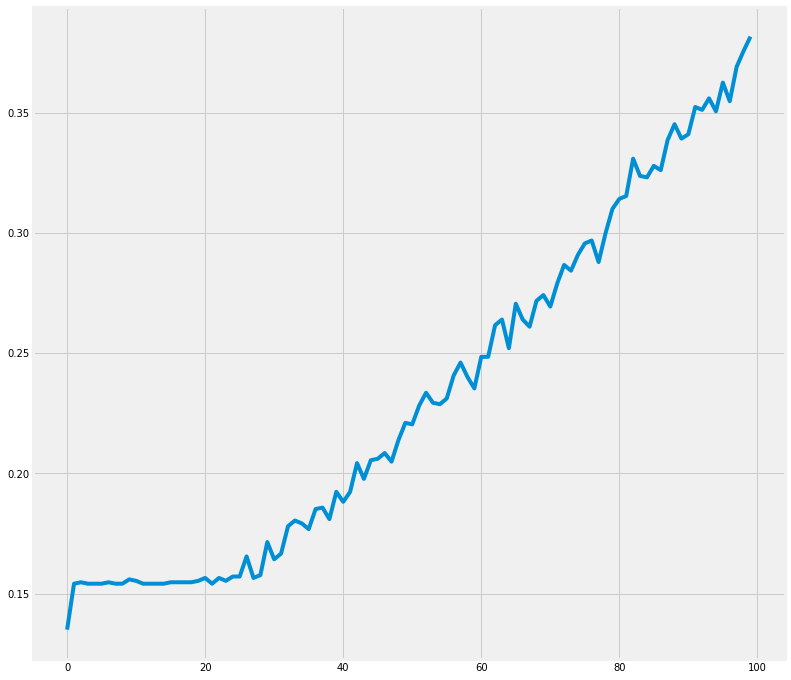

In [71]:
plt.subplots(figsize=(12,12))
sns.lineplot(x=range(100),y=model_history.history['acc'])
#sns.lineplot(x=range(20),y=model_history.history['val_acc'])

In [56]:
sentences[66]

['with', 'be', '\n', 'like', '\n']